In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, classification_report, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

In [5]:
DATA_PATH = 'D:\Projects\train.csv'

In [7]:
df = pd.read_csv(r"D:\Projects\train.csv")
print('Loaded dataset with shape:', df.shape)

Loaded dataset with shape: (800, 22)


In [8]:
display(df.head())

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [9]:
print('\nColumns:', df.columns.tolist())
print('\nTarget distribution:')
print(df['Class/ASD'].value_counts())


Columns: ['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']

Target distribution:
Class/ASD
0    639
1    161
Name: count, dtype: int64


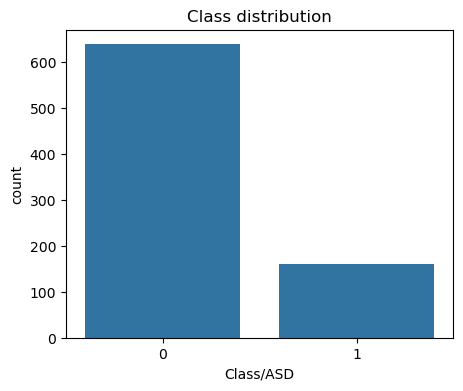

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x='Class/ASD', data=df)
plt.title('Class distribution')
plt.show() 

In [11]:
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
ID                 0
A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [13]:
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

In [14]:
target_col = 'Class/ASD'

In [16]:
cat_cols = []
num_cols = []
for c in df.columns:
    if c == target_col:
        continue
    if df[c].dtype == 'object':
        cat_cols.append(c)
    else:
        num_cols.append(c)


print('\nCategorical columns detected:', cat_cols)
print('Numeric columns detected:', num_cols)


Categorical columns detected: ['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc', 'relation']
Numeric columns detected: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result']


In [18]:
for c in cat_cols:
    print('\nValue counts for', c)
    print(df[c].value_counts(dropna=False).head(10))


Value counts for gender
gender
m    530
f    270
Name: count, dtype: int64

Value counts for ethnicity
ethnicity
White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Name: count, dtype: int64

Value counts for jaundice
jaundice
no     615
yes    185
Name: count, dtype: int64

Value counts for austim
austim
no     669
yes    131
Name: count, dtype: int64

Value counts for contry_of_res
contry_of_res
United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Canada                   30
Afghanistan              22
Netherlands              20
Name: count, dtype: int64

Value counts for used_app_before
used_app_before
no     750
yes     50
Name: count, dtype: int64

Value counts fo

In [20]:
for c in cat_cols:
    df[c] = df[c].replace(['?', 'unknown', 'nan', 'None'], np.nan)

In [21]:
df.columns = [c.strip() for c in df.columns]

In [22]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != target_col]
num_cols = [c for c in df.columns if c != target_col and c not in cat_cols]


print('\nAfter cleanup - categorical:', cat_cols)
print('After cleanup - numeric:', num_cols)


After cleanup - categorical: ['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc', 'relation']
After cleanup - numeric: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result']


In [23]:
## Feature Eng

In [24]:
for c in num_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].mode()[0])

In [25]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

In [27]:
text_flag_cols = [c for c in X.columns if X[c].nunique() == 2 and X[c].dropna().unique().dtype == object]
for c in text_flag_cols:
    unique_vals = sorted(list(X[c].dropna().unique()))
    if set([val.lower() for val in unique_vals]) == set(['no','yes']):
        X[c] = X[c].map({'no':0, 'yes':1})

In [28]:
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]
print('\nFinal categorical cols for encoding:', cat_cols)
print('Final numeric cols:', num_cols)


Final categorical cols for encoding: ['gender', 'ethnicity', 'contry_of_res', 'age_desc', 'relation']
Final numeric cols: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'jaundice', 'austim', 'used_app_before', 'result']


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)



Train shape: (640, 20) Test shape: (160, 20)


In [31]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

In [33]:
ros = RandomOverSampler(random_state=42)

In [35]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}
if has_xgb:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


trained_models = {}
results = []


for name, clf in models.items():
    print(f"\nTraining {name} ...")
    pipe = ImbPipeline(steps=[('preproc', preprocessor), ('ros', ros), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None


    print(f"{name} -> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc}")
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


    trained_models[name] = pipe
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC_AUC': roc})


Training LogisticRegression ...
LogisticRegression -> Acc: 0.8063, Prec: 0.5102, Rec: 0.7812, F1: 0.6173, ROC-AUC: 0.886474609375
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       128
           1       0.51      0.78      0.62        32

    accuracy                           0.81       160
   macro avg       0.72      0.80      0.74       160
weighted avg       0.85      0.81      0.82       160

Confusion Matrix:
 [[104  24]
 [  7  25]]

Training SVM ...
SVM -> Acc: 0.8313, Prec: 0.5532, Rec: 0.8125, F1: 0.6582, ROC-AUC: 0.86572265625
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       128
           1       0.55      0.81      0.66        32

    accuracy                           0.83       160
   macro avg       0.75      0.82      0.77       160
weighted avg       0.87      0.83      0.84       160

Confusion Matrix:
 [[107  21]
 [  6  26]]

Training RandomForest ...
Rand

In [36]:
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print('\nModel comparison:')
print(results_df)


Model comparison:
                Model  Accuracy  Precision   Recall        F1   ROC_AUC
1                 SVM   0.83125   0.553191  0.81250  0.658228  0.865723
2        RandomForest   0.83750   0.583333  0.65625  0.617647  0.889282
0  LogisticRegression   0.80625   0.510204  0.78125  0.617284  0.886475
3             XGBoost   0.83125   0.571429  0.62500  0.597015  0.864014


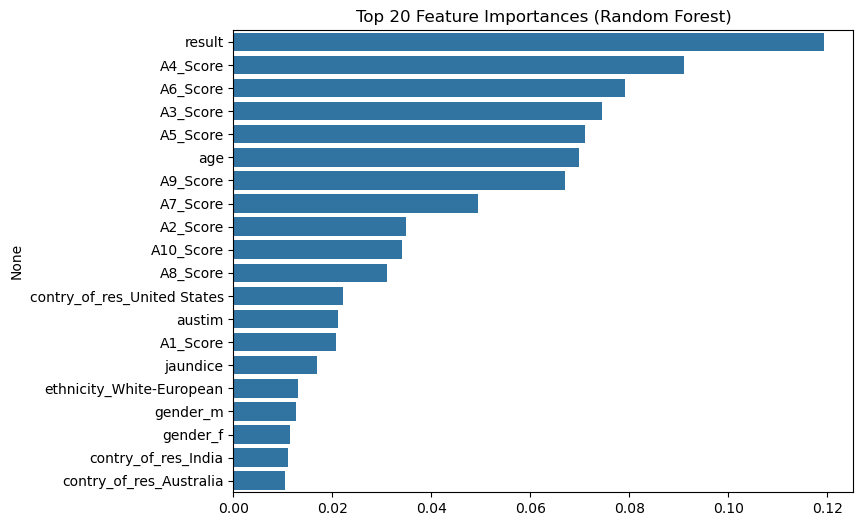

In [38]:
if 'RandomForest' in trained_models:
    rf_pipe = trained_models['RandomForest']
    # Extract feature names after preprocessing
    ohe = rf_pipe.named_steps['preproc'].named_transformers_.get('cat')
    # build feature names array
    num_feats = num_cols
    cat_feats = []
    if len(cat_cols) > 0:
        cat_encoder = rf_pipe.named_steps['preproc'].named_transformers_.get('cat').named_steps['onehot']
        cat_names = list(cat_encoder.get_feature_names_out(cat_cols))
        cat_feats = cat_names
    feat_names = num_feats + cat_feats
    
    
    rf_clf = rf_pipe.named_steps['clf']
    importances = rf_clf.feature_importances_
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.show()

In [39]:
import joblib
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
save_path = r"D:\Projects\best_autism_model.pkl"
print(f"\nBest model by F1: {best_model_name}. Saving to {save_path}")
joblib.dump(best_model, save_path)
print("Model saved successfully!")



Best model by F1: SVM. Saving to D:\Projects\best_autism_model.pkl
Model saved successfully!


In [43]:
import os
model_path = r"D:\Projects\best_autism_model.pkl"

if os.path.exists(model_path):
    print(f"✅ Model file found at: {model_path}")
    
    loaded_model = joblib.load(model_path)
    print("✅ Model loaded successfully.")
    
    sample = X_test.iloc[[0]]  
    true_label = y_test.iloc[0]
    
    pred = loaded_model.predict(sample)[0]
    prob = loaded_model.predict_proba(sample)[0][1] if hasattr(loaded_model, "predict_proba") else None
    
    print("\nSample prediction check:")
    print(f"True label      : {true_label}")
    print(f"Predicted label : {pred}")
    if prob is not None:
        print(f"Predicted probability (Autism): {prob:.4f}")
else:
    print(f" Model file not found at: {model_path}")


✅ Model file found at: D:\Projects\best_autism_model.pkl
✅ Model loaded successfully.

Sample prediction check:
True label      : 0
Predicted label : 0
Predicted probability (Autism): 0.0075
